In [26]:
!pip3 install sgp4
!pip3 install skyfield
!pip3 install pyIGRF

In [69]:
%run math_utils.ipynb

In [70]:
from sgp4.api import Satrec, WGS72
from skyfield.api import EarthSatellite, Time, load, wgs84
import pyIGRF
import matplotlib.pyplot as plt
import numpy as np

In [211]:
class Spacecraft_Model():

    # Spacecraft general parameters
    m = 6      # [kg] weight
    h = 0.34   # [m] hieght of chassis
    w = 0.1    # [m] width of chassis
    d = 0.1    # [m] depth of chassis
    J = [[(1/12)*m*(h**2 + d**2), 0, 0], 
         [0, (1/12)*m*(w**2 + d**2), 0], 
         [0, 0, (1/12)*m*(h**2 + w**2)]]

    # Generate a satellite orbit using orbital elements
    # This orbit is for the ISS
    # TODO: change to a more realistic orbit for this CubeSat
    satrec = Satrec()
    satrec.sgp4init(
        WGS72,           # gravity model
        'i',             # 'a' = old AFSPC mode, 'i' = improved mode
        5,               # satnum: Satellite number
        18441.785,       # epoch: days since 1949 December 31 00:00 UT
        2.8098e-05,      # bstar: drag coefficient (/earth radii)
        6.969196665e-13, # ndot: ballistic coefficient (revs/day)
        0.0,             # nddot: second derivative of mean motion (revs/day^3)
        0.1859667,       # ecco: eccentricity
        5.7904160274885, # argpo: argument of perigee (radians)
        0.5980929187319, # inclo: inclination (radians)
        0.3373093125574, # mo: mean anomaly (radians)
        0.0472294454407, # no_kozai: mean motion (radians/minute)
        6.0863854713832, # nodeo: right ascension of ascending node (radians)
    )

    # Create a EarthSatellite object using the generated satellite orbit
    ts = load.timescale()
    sat = EarthSatellite.from_satrec(satrec,ts)
    t0 = sat.epoch

    orbit_len = (2*np.pi/sat.model.no_kozai)*60    # [s] orbit duration

    r0 = sat.at(t0).position.km
    v0 = sat.at(t0).velocity.km_per_s
    
    # Find the ideal orientation of the spacecraft in the ICRF
    b_x = -normalize(r0)
    b_y = normalize(v0)
    b_z = cross(b_x, b_y)

    # Construct the nominal DCM from inertial to body from the body axes
    # Compute the equilvalent quaternion
    dcm_0_nominal = np.stack([b_x, b_y, b_z])
    q_0_nominal = dcm_to_quaternion(dcm_0_nominal)

    # Compute the nominal angular velocity required to maintain the reference attitude
    w_nominal_i = (sat.model.no_kozai / 60) * normalize(cross(r0, v0))
    w_nominal_b = np.matmul(dcm_0_nominal, w_nominal_i)
    
    def __init__(self, dt):
        self.dt = dt

        # Provide some initial offset in both the attitude and angular velocity
        # q_offset = [0, np.sin(2*np.pi / 180 / 2), 0, np.cos(2*np.pi / 180 / 2)]
        # q_0 = quaternion_multiply(q_offset, q_0_nominal)
        q_0 = Spacecraft_Model.q_0_nominal
        w_offset = np.array([0.005, 0 ,0])
        w_0 = Spacecraft_Model.w_nominal_b + w_offset
        # w_0 = np.array([0, 0, 0])

        self.t = Spacecraft_Model.t0
        self.q_t = q_0
        self.w_t = w_0
    
    def get_position(self):
        return self.sat.at(self.t).position.km

    def get_velocity(self):
        return self.sat.at(self.t).velocity.km_per_s

    # Get the value of the Earth's magnetic field
    def get_magnetic_field(self):
        pos = self.sat.at(self.t)
        lat, lon = wgs84.latlon_of(pos)
        alt = wgs84.height_of(pos)
        return pyIGRF.igrf_value(lat.degrees, lon.degrees, alt.km, date.J)
        
    # Computes 
    def get_angular_acceleration(self):
        # For now, assume torques are zero
        M = np.array([0, 0, 0])
        J_inv = np.linalg.inv(self.J)
        a = -np.matmul(J_inv, cross(self.w_t, np.matmul(self.J, self.w_t))) + np.matmul(J_inv, M)
        return a

    def tick(self):
        # Update angular velocity
        a = self.get_angular_acceleration()
        self.w_t = self.w_t + a * self.dt

        # Update orientation
        q_w = np.array([*self.w_t, 0])
        self.q_t = self.q_t + 0.5 * quaternion_multiply(q_w,self.q_t) * dt
        self.q_t = normalize(self.q_t)

        # Update time - need to convert seconds to days
        self.t = self.t + self.dt/(24*60*60)
    
    def graph_orbit(self):
        # Graph Earth
        re = 6378.   # [km] radius of Earth
        
        theta = np.linspace(0, 2*np.pi, 201)
        cth, sth, zth = (lambda theta=theta: [f(theta) for f in (np.cos, np.sin, np.zeros_like)])()
        lon0 = re*np.vstack((cth, zth, sth))
        lons = []
        for phi in (np.pi/180)*np.arange(0,180,15):
            cph, sph = (lambda phi=phi: [f(phi) for f in (np.cos, np.sin)])()
            lon = np.vstack((lon0[0]*cph - lon0[1]*sph,
                             lon0[1]*cph + lon0[0]*sph,
                             lon0[2]))
            lons.append(lon)
    
        lat0 = re*np.vstack((cth,sth,zth))
        lats = []
        for phi in (np.pi/180)*np.arange(-75, 90, 15):
            cph, sph = (lambda phi=phi: [f(phi) for f in (np.cos, np.sin)])()
            lat = re*np.vstack((cth*cph, sth*cph, zth+sph))
            lats.append(lat)
    
        fig = plt.figure(figsize=[10, 8])

        # Graph spacecraft orbit
        ax  = fig.add_subplot(1, 1, 1, projection='3d')
           
        sat = self.sat
        
        t0 = Spacecraft_Model.t0
        t1 = t0 + (2*np.pi/sat.model.no_kozai)/(60*24)
        time = Spacecraft_Model.ts.linspace(t0, t1, 200)
    
        sat_pos = sat.at(time).position.km
        sat_posecl = sat.at(time).ecliptic_position().km

        x, y, z = sat_pos
        ax.plot(x, y, z)
        for x, y, z in lons:
            ax.plot(x, y, z, '-k')
        for x, y, z in lats:
            ax.plot(x, y, z, '-k')
            
        plt.show()  

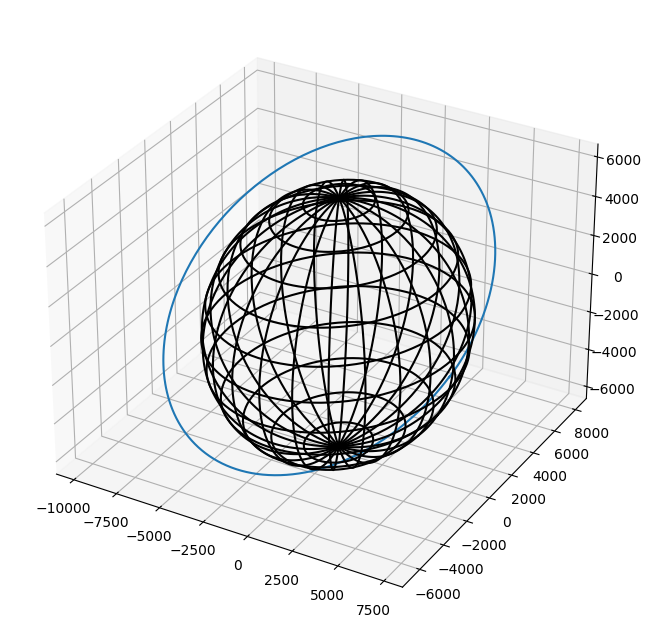

In [212]:
dt = 0.1
s1 = Spacecraft_Model(dt)
s1.graph_orbit()

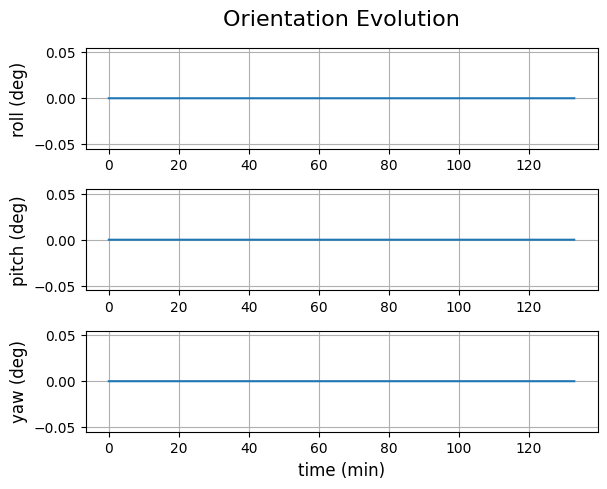

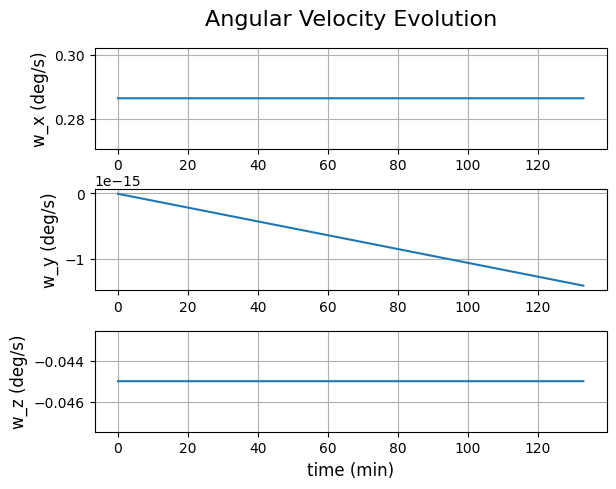

In [215]:
s2 = Spacecraft_Model(dt)

time = np.arange(0,Spacecraft_Model.orbit_len,dt)

roll_history, pitch_history, yaw_history = np.zeros(len(time)), np.zeros(len(time)), np.zeros(len(time))
w_history = np.zeros((len(time), 3))

for i in range(time.size):
    s2.tick()
    w_history[i] = s2.w_t

time = time / 60

fig1 = plt.figure()
fig1.suptitle('Orientation', fontsize=16)

# Plot roll:
ax1 = fig1.add_subplot(3, 1, 1)
ax1.plot(time, np.rad2deg(roll_history))
ax1.set_ylabel('roll (deg)', fontsize=12)
ax1.grid(True)

# Plot pitch:
ax2 = fig1.add_subplot(3, 1, 2)
ax2.plot(time, np.rad2deg(pitch_history))
ax2.set_ylabel('pitch (deg)', fontsize=12)
ax2.grid(True)

# Plot yaw:
ax3 = fig1.add_subplot(3, 1, 3)
ax3.plot(time, np.rad2deg(yaw_history))
ax3.set_ylabel('yaw (deg)', fontsize=12)
ax3.set_xlabel('time (min)', fontsize=12)
ax3.grid(True)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

fig2 = plt.figure()
fig2.suptitle('Angular Velocity', fontsize=16)

# Plot rolling:
ax1 = fig2.add_subplot(3, 1, 1)
ax1.plot(time, np.rad2deg(w_history[:, 0]))
ax1.set_ylabel('w_x (deg/s)', fontsize=12)
ax1.grid(True)

# Plot pitching:
ax2 = fig2.add_subplot(3, 1, 2)
ax2.plot(time, np.rad2deg(w_history[:, 1]))
ax2.set_ylabel('w_y (deg/s)', fontsize=12)
ax2.grid(True)

# Plot yawing:
ax3 = fig2.add_subplot(3, 1, 3)
ax3.plot(time, np.rad2deg(w_history[:, 2]))
ax3.set_ylabel('w_z (deg/s)', fontsize=12)
ax3.set_xlabel('time (min)', fontsize=12)
ax3.grid(True)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()